In [1]:
%config IPCompleter.greedy=True
import numpy as np
import pandas as pd
import psycopg2
import matplotlib.pyplot as plt
import time
import re
import scipy
from datetime import time, timedelta
import seaborn as sns
pd.set_option('display.max_columns', 100)

In [8]:
'''
*****自定义数据提取的代码*****
输入：
    sql:常规sql代码

输出：
    dataframe格式数据表格
    
备注：
    当sql代码出错的时候，函数会返回sql的报错内容
'''
def get_data_MIMIC(sql):
    conn = psycopg2.connect(database="mimiciv2_2",user="postgres",
                           password="postgres",
                            host="10.245.99.98",
                            #ost="172.16.2.76",
                            port="5433")
    cur = conn.cursor()
    try:
        cur.execute(sql)
        #获取表的所有字段名称
        coloumns = [row[0] for row in cur.description]
        result = [[str(item) for item in row] for row in cur.fetchall()]
        return pd.DataFrame(result,columns=coloumns)
    except Exception as ex:
        print(ex)
    finally:
        conn.close()

In [3]:
def trans_id(df):
    for i in ['subject_id','hadm_id','stay_id']:
        if i in df.columns.tolist():
            if df[i].dtype == object:
                if ((df[i]== 'None')|(df[i]== 'Null')).any():
                    df[i].replace('None',np.nan,inplace = True)
                    df[i].replace('Null',np.nan,inplace = True)
                    df[i] = df[i].astype(float)
                else:
                    df[i] = df[i].astype(float)

In [4]:
def trans_time(t):
    if t == 'None':
        return np.datetime64('NaT')
    elif pd.isna(t):
        return np.datetime64('NaT')
    else:
        return np.datetime64(t)

In [5]:
def trans_float(df):
    for i in df.columns:
        if df[i].dtype == object:
            if ((df[i]== 'None')|(df[i]== 'Null')).any():
                df[i].replace('None',np.nan,inplace = True)
                df[i].replace('Null',np.nan,inplace = True)
                df[i] = df[i].astype(float)
            else:
                df[i] = df[i].astype(float)

# 提取微生物信息

In [9]:
microevents = get_data_MIMIC('''
set search_path to mimiciv2_2;
select distinct *
from mimiciv_hosp.microbiologyevents
''')

In [10]:
# org_mimiciv = pd.DataFrame(microevents.org_name.value_counts())
# org_mimiciv = org_mimiciv.reset_index()
# org_mimiciv.columns = ['org_name','number']
# org_name = pd.read_excel('org_name.xlsx',sheet_name = '含真菌')
# org_mimiciv_tot = pd.merge(org_mimiciv, org_name, how = 'left', on = ['org_name'])
# org_mimiciv_tot.to_excel('micro_label_mimiciv_tot_tobefinished.xlsx')

In [11]:
icustays = get_data_MIMIC('''
set search_path to mimiciv2_2;
select distinct *
from mimiciv_derived.icustay_detail
''')

In [12]:
microevents = microevents[microevents['subject_id'].isin(icustays['subject_id'])]

In [14]:
org_name_sel = pd.read_excel('org_name.xlsx',sheet_name='sel')

In [15]:
test_name_sel = pd.read_csv('test_name_sel.csv').iloc[:,0].to_list()

In [16]:
trans_id(microevents)

In [17]:
microevents = microevents[microevents['test_name'].isin(test_name_sel)]

In [18]:
microevents[microevents['test_name'] == 'DIRECT AFB STAIN-BI']

,microevent_id,subject_id,hadm_id,micro_specimen_id,order_provider_id,chartdate,charttime,spec_itemid,spec_type_desc,test_seq,storedate,storetime,test_itemid,test_name,org_itemid,org_name,isolate_num,quantity,ab_itemid,ab_name,dilution_text,dilution_comparison,dilution_value,interpretation,comments


In [19]:
test_name_sel

['URINE CULTURE',
 'Blood Culture, Routine',
 'MRSA SCREEN',
 'RESPIRATORY CULTURE',
 'ANAEROBIC CULTURE',
 'FLUID CULTURE',
 'WOUND CULTURE',
 'FUNGAL CULTURE',
 'FECAL CULTURE',
 'CAMPYLOBACTER CULTURE',
 'DIRECT AFB STAIN-BI',
 'Rapid Respiratory Viral Antigen Test',
 'Respiratory Viral Culture',
 'TISSUE',
 'Staph aureus Screen',
 'LEGIONELLA CULTURE',
 'R/O VANCOMYCIN RESISTANT ENTEROCOCCUS',
 'FECAL CULTURE - R/O E.COLI 0157:H7',
 'BLOOD/FUNGAL CULTURE',
 'Fluid Culture in Bottles',
 'BLOOD/AFB CULTURE',
 'FECAL CULTURE - R/O YERSINIA',
 'FECAL CULTURE - R/O VIBRIO',
 'NOCARDIA CULTURE',
 'VARICELLA-ZOSTER CULTURE',
 'CHROMOSOME ANALYSIS-BONE MARROW',
 'THROAT - R/O BETA STREP',
 'MTB Direct Amplification',
 'Tissue Culture-Bone Marrow',
 'RUBEOLA ANTIBODY, IgG',
 'MONOSPOT',
 'FUNGAL CULTURE (HAIR/SKIN/NAILS)',
 'Tissue Culture - Neoplastic Blood',
 'BRUCELLA BLOOD CULTURE',
 'R/O GROUP B BETA STREP',
 'Swab - R/O Yeast - IC',
 'Carbapenemase Resistant Enterobacteriaceae Screen'

In [20]:
for i in ['chartdate','charttime','storedate','storetime']:
    microevents[i] = microevents[i].apply(trans_time)

In [21]:
microevents['charttime'] = microevents[['chartdate','charttime']].\
apply(lambda x: x[0] if pd.isna(x[1]) else x[1], axis = 1)

In [22]:
microevents['storetime'] = microevents[['storedate','storetime']].\
apply(lambda x: x[0] if pd.isna(x[1]) else x[1],axis =1)

In [23]:
microevents_2 = pd.merge(microevents,org_name_sel[['org_name','org_category']],\
                         how = 'left', on = ['org_name'])

In [24]:
microevents_2[['subject_id','micro_specimen_id','org_name']].\
drop_duplicates().org_name.value_counts().head(20)

None                                               576381
STAPH AUREUS COAG +                                 17237
YEAST                                               17000
ESCHERICHIA COLI                                    15067
STAPHYLOCOCCUS, COAGULASE NEGATIVE                   8349
ENTEROCOCCUS SP.                                     7641
CANCELLED                                            6583
KLEBSIELLA PNEUMONIAE                                6129
PSEUDOMONAS AERUGINOSA                               6097
MIXED BACTERIAL FLORA                                3607
GRAM POSITIVE BACTERIA                               3217
POSITIVE FOR METHICILLIN RESISTANT STAPH AUREUS      2776
GRAM NEGATIVE ROD(S)                                 2726
PROTEUS MIRABILIS                                    2651
CORYNEBACTERIUM SPECIES (DIPHTHEROIDS)               2193
BETA STREPTOCOCCUS GROUP B                           1980
ENTEROCOCCUS FAECIUM                                 1882
VIRIDANS STREP

In [25]:
microevents_2[['subject_id','micro_specimen_id','org_name','org_category']].\
drop_duplicates().org_category.value_counts().head(10)

Enterobacteriaceae        30637
Staphylococcus aureus     20013
Enterococcus spp.         11130
Pseudomonas aeruginosa     6107
Acinetobacter spp.          572
Name: org_category, dtype: int64

In [26]:
microevents_2[['subject_id','micro_specimen_id','org_name','org_category',\
               'ab_name','interpretation']].ab_name.value_counts()

None                    724301
GENTAMICIN               54212
TRIMETHOPRIM/SULFA       44602
CEFTAZIDIME              36427
CIPROFLOXACIN            36326
MEROPENEM                36147
TOBRAMYCIN               36095
CEFEPIME                 36051
CEFTRIAXONE              30333
PIPERACILLIN/TAZO        30052
AMPICILLIN               25316
AMPICILLIN/SULBACTAM     24197
NITROFURANTOIN           23788
CEFAZOLIN                22535
VANCOMYCIN               20726
LEVOFLOXACIN             19466
TETRACYCLINE             18621
ERYTHROMYCIN             18069
OXACILLIN                17827
CLINDAMYCIN              16461
RIFAMPIN                  7988
PENICILLIN G              6944
AMIKACIN                  3880
PIPERACILLIN              3675
LINEZOLID                 3514
CEFUROXIME                3179
DAPTOMYCIN                2106
IMIPENEM                  1290
Name: ab_name, dtype: int64

In [27]:
mdr_cal = microevents_2[['subject_id','micro_specimen_id','org_name',\
'org_category','ab_name','interpretation']].drop_duplicates()

In [28]:
MDR_CAL_cha = mdr_cal.set_index(['subject_id','micro_specimen_id',\
'org_name','org_category','ab_name'], append=True).unstack(-1).reset_index()

In [29]:
MDR_CAL_cha = MDR_CAL_cha.iloc[:,1:]
MDR_CAL_cha.columns = ['subject_id','micro_specimen_id',\
'org_name','org_category'] + MDR_CAL_cha['interpretation'].columns.to_list()

In [30]:
MDR_CAL_cha.drop(columns = 'None', inplace = True)

In [31]:
MDR_CAL_cha.drop_duplicates().org_name.value_counts()

None                       576381
ESCHERICHIA COLI           176479
STAPH AUREUS COAG +         97944
KLEBSIELLA PNEUMONIAE       64102
PSEUDOMONAS AERUGINOSA      39918
                            ...  
NEISSERIA SUBFLAVA              1
POSITIVE FOR ADENOVIRUS         1
SALMONELLA NEWPORT              1
STEMPHYLIUM SP.                 1
PHOMA SPECIES                   1
Name: org_name, Length: 472, dtype: int64

In [32]:
MDR_CAL_cha_test = MDR_CAL_cha.copy()

#抗生素的名称列表
ab_list = MDR_CAL_cha.columns.to_list()
del ab_list[0:4]

for i in ab_list:
    MDR_CAL_cha_test[i] = MDR_CAL_cha_test[i].astype(str)

In [33]:
MDR_CAL_cha_test = MDR_CAL_cha_test.drop(columns = 'org_category')

In [34]:
MDR_CAL_cha_test = MDR_CAL_cha_test.groupby(['subject_id','micro_specimen_id','org_name']).sum().reset_index()

In [35]:
import re

def find_r(x):
    if re.search('R',x):
        return 'R'
    elif re.search('I',x):
        return 'I'
    elif re.search('S',x):
        return 'S'
    else:
        return np.nan

for i in ab_list:
    MDR_CAL_cha_test[i] = MDR_CAL_cha_test[i].apply(lambda x:find_r(x))

MDR_CAL_conc = MDR_CAL_cha_test.drop_duplicates()

In [36]:
# #进行转化为列之后的规整--相当于加和

# #抗生素的名称列表
# ab_list = MDR_CAL_cha.columns.to_list()
# del ab_list[0:3]

# #定义转化函数
# def ab_con(df):
#     for i in ab_list:
#         if (df[i]== 'S').any():
#             df[i] = 'S'
#         elif (df[i]== 'I').any():
#             df[i] = 'I'
#         elif (df[i]== 'R').any():
#             df[i] = 'R'
#         else:
#             df[i] = np.nan
#     return df

# MDR_CAL_test = MDR_CAL_cha.copy()
# #grouped = MDR_CAL_test.groupby(['subject_id','micro_specimen_id','org_name'])
# MDR_CAL_test_re = MDR_CAL_test.groupby(['subject_id',\
# 'micro_specimen_id','org_category','org_name']).apply(ab_con)
# MDR_CAL_conc = MDR_CAL_test_re.drop_duplicates()

In [37]:
#MDR_CAL_test.groupby(['subject_id','micro_specimen_id','org_category','org_name']).size()

In [38]:
#MDR_CAL_conc.drop(columns = ['org_category'], inplace = True)

In [39]:
MDR_CAL_cat = pd.merge(MDR_CAL_conc,org_name_sel[['org_name','org_category']],\
how = 'left', on = ['org_name'])#.org_category.value_counts()

In [40]:
#5个不同组别的微生物ID
org_pieces = dict(list(org_name_sel['org_itemid'].groupby(org_name_sel['org_category'])))

St_itemid = org_pieces['Staphylococcus aureus'].tolist()
Eb_itemid = org_pieces['Enterobacteriaceae'].tolist()
Ec_itemid = org_pieces['Enterococcus spp.'].tolist()
Ps_itemid = org_pieces['Pseudomonas aeruginosa'].tolist()
Ac_itemid = org_pieces['Acinetobacter spp.'].tolist()

St_itemid = [str(i) for i in St_itemid]
Eb_itemid = [str(i) for i in Eb_itemid]
Ec_itemid = [str(i) for i in Ec_itemid]
Ps_itemid = [str(i) for i in Ps_itemid]
Ac_itemid = [str(i) for i in Ac_itemid]

In [41]:
#5个不同组别的微生物的名称
org_pieces = dict(list(org_name_sel['org_name'].groupby(org_name_sel['org_category'])))

St_name = org_pieces['Staphylococcus aureus'].tolist()
Eb_name = org_pieces['Enterobacteriaceae'].tolist()
Ec_name = org_pieces['Enterococcus spp.'].tolist()
Ps_name = org_pieces['Pseudomonas aeruginosa'].tolist()
Ac_name = org_pieces['Acinetobacter spp.'].tolist()

In [42]:
Eb_exc_amino_list = ['PROVIDENCIA RETTGERI', 'PROVIDENCIA STUARTII']
Eb_exc_cefazolin_list = [
    'CITROBACTER FREUNDII COMPLEX', 'ENTEROBACTER AEROGENES',
    'ENTEROBACTER CLOACAE COMPLEX', 'ENTEROBACTER CLOACAE', 'HAFNIA ALVEI',
    'MORGANELLA MORGANII', 'PROTEUS PENNERI', 'PROTEUS VULGARIS',
    'PROTEUS VULGARIS GROUP', 'PROVIDENCIA RETTGERI', 'PROVIDENCIA STUARTII',
    'SERRATIA MARCESCENS'
]
Eb_exc_cefuroxime_list = [
    'MORGANELLA MORGANII', 'PROTEUS PENNERI', 'PROTEUS VULGARIS',
    'PROTEUS VULGARIS GROUP', 'SERRATIA MARCESCENS'
]
Eb_exc_ampicillin_list = [
    'CITROBACTER KOSERI', 'CITROBACTER FREUNDII COMPLEX',
    'ENTEROBACTER AEROGENES', 'ENTEROBACTER CLOACAE COMPLEX',
    'ENTEROBACTER CLOACAE', 'HAFNIA ALVEI', 'KLEBSIELLA PNEUMONIAE',
    'KLEBSIELLA OXYTOCA', 'MORGANELLA MORGANII', 'PROTEUS PENNERI',
    'PROTEUS VULGARIS', 'PROTEUS VULGARIS GROUP', 'PROVIDENCIA RETTGERI',
    'PROVIDENCIA STUARTII', 'SERRATIA MARCESCENS'
]
Eb_exc_ampicillinsulbactam_list = [
    'CITROBACTER FREUNDII COMPLEX', 'CITROBACTER KOSERI',
    'ENTEROBACTER AEROGENES', 'ENTEROBACTER CLOACAE COMPLEX',
    'ENTEROBACTER CLOACAE', 'HAFNIA ALVEI', 'PROVIDENCIA RETTGERI',
    'SERRATIA MARCESCENS'
]
Eb_exc_teracycline_list = [
    'MORGANELLA MORGANII', 'PROTEUS MIRABILIS','PROTEUS PENNERI',
    'PROTEUS VULGARIS', 'PROTEUS VULGARIS GROUP', 'PROVIDENCIA RETTGERI',
    'PROVIDENCIA STUARTII'
]

In [43]:
def MDR(df):
    #金黄色葡萄球菌
    if df['org_name'] in St_name:
        if df['org_name'] == 'POSITIVE FOR METHICILLIN RESISTANT STAPH AUREUS':
            return 'MRSA', 1
        elif df['org_name'] == 'S. AUREUS POSITIVE; MRSA POSITIVE':
            return 'MRSA', 1
        else:
            St_dict = {}
            St_sum = 0
            St_ab_list = []
            #氨基糖苷-庆大霉素
            if df['GENTAMICIN'] == 'I' or df['GENTAMICIN'] == 'R':
                St_dict['Aminoglycosides'] = 1
            #安沙霉素-利福平
            if df['RIFAMPIN'] == 'I' or df['RIFAMPIN'] == 'R':
                St_dict['Ansamycins'] = 1
            #抗MRSA 头孢菌素类
            #抗葡萄球菌β内酰胺或头孢
            if (df[['AMPICILLIN','AMPICILLIN/SULBACTAM','CEFAZOLIN',\
                'CEFEPIME','CEFTAZIDIME','CEFTRIAXONE','CEFUROXIME',\
                'OXACILLIN','PENICILLIN G','PIPERACILLIN','PIPERACILLIN/TAZO']] == 'I').any() or \
                (df[['AMPICILLIN','AMPICILLIN/SULBACTAM','CEFAZOLIN',\
                'CEFEPIME','CEFTAZIDIME','CEFTRIAXONE','CEFUROXIME',\
                'OXACILLIN','PENICILLIN G','PIPERACILLIN','PIPERACILLIN/TAZO']] == 'R').any():
                St_dict['LactamsCephamycins'] = 1
            #氟喹诺酮-环丙沙星
            if df['CIPROFLOXACIN']=='I' or df['CIPROFLOXACIN']=='R':
                St_dict['Fluoroquinolones'] = 1
            #叶酸途径抑制剂-甲氧苄啶 复方新诺明
            if df['TRIMETHOPRIM/SULFA']=='I' or df['TRIMETHOPRIM/SULFA']=='R':
                St_dict['Folate'] = 1
            #Fucidanes
            #糖肽类-万古霉素
            if df['VANCOMYCIN'] == 'I' or df['VANCOMYCIN'] == 'R':
                St_dict['Glycopeptides'] = 1
            #甘氨环素
            #林可酰胺类-克林霉素
            if df['CLINDAMYCIN'] == 'I' or df['CLINDAMYCIN'] == 'R':
                St_dict['Lincosamides'] = 1
            #脂肽类-达托霉素
            if df['DAPTOMYCIN'] == 'I' or df['DAPTOMYCIN'] == 'R':
                St_dict['Lipopeptides'] = 1
            #大环内酯类-红霉素
            if df['ERYTHROMYCIN'] == 'I' or df['ERYTHROMYCIN'] == 'R':
                St_dict['Macrolides'] = 1
            #恶唑烷酮类-利奈唑胺
            if df['LINEZOLID'] == 'I' or df['LINEZOLID'] == 'R':
                St_dict['Oxazolidinones'] = 1
            #苯丙醇类
            #磷酶酸类
            #链阳霉素类
            #四环素类-四环素
            if df['TETRACYCLINE'] == 'I' or df['TETRACYCLINE'] == 'R':
                St_dict['Tetracyclines'] = 1
            
            for i in St_dict:
                St_sum += St_dict[i]
                St_ab_list.append(i)
            if St_sum>=3:
                return ";".join(St_ab_list), 1
            else:
                return ";".join(St_ab_list), 0
    #肠球菌
    elif df['org_name'] in Ec_name:
        Ec_dict = {}
        Ec_sum = 0
        Ec_ab_list = []
        #氨基糖苷-高浓度庆大霉素
        #链霉素-链霉素
        #碳青霉烯类-亚胺培南、美罗培南
        if (df[['IMIPENEM','MEROPENEM']] == 'I').any() or \
                (df[['IMIPENEM','MEROPENEM']] == 'R').any():
            if df['org_name'] != 'ENTEROCOCCUS FAECIUM': 
#只有不是屎肠球菌才执行这条命令。如果是屎肠球菌，则跳过，字典里不会纳入碳青霉烯类的信息。
                Ec_dict['Carbapenems'] = 1
        #氟喹诺酮-环丙沙星、左氧氟沙星
        if (df[['CIPROFLOXACIN','LEVOFLOXACIN']]=='I').any() or \
                (df[['CIPROFLOXACIN','LEVOFLOXACIN']]=='R').any():
            Ec_dict['Fluroquinolones'] = 1
        #糖肽类-万古霉素
        if df['VANCOMYCIN'] == 'I' or df['VANCOMYCIN'] == 'R':
            Ec_dict['Glycopeptides'] = 1
        #甘氨环素类
        #脂肽类-达托霉素
        if df['DAPTOMYCIN'] == 'I' or df['DAPTOMYCIN'] == 'R':
            Ec_dict['Lipopeptides'] = 1
        #恶唑烷酮类-利奈唑胺
        if df['LINEZOLID'] == 'I' or df['LINEZOLID'] == 'R':
            Ec_dict['Oxazolidinones'] = 1
        #青霉素类-氨苄西林
        if df['AMPICILLIN'] == 'I' or df['AMPICILLIN'] == 'R':
            Ec_dict['Penicillins'] = 1
        #链阳霉素类
        #四环素类
        if df['TETRACYCLINE'] == 'I' or df['TETRACYCLINE'] == 'R':
            Ec_dict['Tetracyclines'] = 1
        
        for i in Ec_dict:
            Ec_sum += Ec_dict[i]
            Ec_ab_list.append(i)
        if Ec_sum>=3:
            return ";".join(Ec_ab_list), 1
        else:
            return ";".join(Ec_ab_list), 0
    #肠杆菌
    elif df['org_name'] in Eb_name:
        Eb_dict = {}
        Eb_sum = 0
        Eb_ab_list = []
        #氨基糖苷-庆大霉素、妥布霉素、阿米卡星
        if (df[['GENTAMICIN','TOBRAMYCIN']] == 'I').any() \
            or (df[['GENTAMICIN','TOBRAMYCIN']] == 'R').any():
            if df['org_name'] not in Eb_exc_amino_list:
                Eb_dict['Aminoglycosides'] = 1
        if df['AMIKACIN'] == 'I' or df['AMIKACIN'] == 'R':
            Eb_dict['Aminoglycosides'] = 1
        #抗MRSA头孢-头孢洛林
        #抗假单胞菌青霉素+β-内酰胺酶抑制剂 - 哌拉西林-他唑巴坦
        if df['PIPERACILLIN/TAZO'] == 'I' or df['PIPERACILLIN/TAZO'] == 'R':
            Eb_dict['AntiPenicillins&Lactamaseinhibitors'] = 1
        #碳青霉烯类 - 亚胺培南、美罗培南
        if (df[['IMIPENEM','MEROPENEM']] == 'I').any() or \
            (df[['IMIPENEM','MEROPENEM']] == 'R').any():
            Eb_dict['Carbapenems'] = 1
        #非超广谱头孢菌素-1、2代头孢 - 头孢唑林、头孢呋辛
        if df['CEFAZOLIN']=='I' or df['CEFAZOLIN']=='R':
            if df['org_name'] not in Eb_exc_cefazolin_list:
                Eb_dict['NESCephalosporins'] = 1
        if df['CEFUROXIME']=='I' or df['CEFUROXIME']=='R':
            if df['org_name'] not in Eb_exc_cefuroxime_list:
                Eb_dict['NESCephalosporins'] = 1
        #超广谱头孢菌素-3、4代头孢 - 头孢曲松、头孢他啶、头孢吡肟
        if (df[['CEFTRIAXONE','CEFTAZIDIME','CEFEPIME']]=='I').any() \
            or (df[['CEFTRIAXONE','CEFTAZIDIME','CEFEPIME']]=='R').any():
            Eb_dict['ESCephalosporins'] = 1
        #头孢菌素类 Cephamycins
        #氟喹诺酮类 - 环丙沙星
        if df['CIPROFLOXACIN'] == 'I' or df['CIPROFLOXACIN'] == 'R':
            Eb_dict['Fluoroquinolones'] = 1
        #叶酸途径抑制剂-甲氧苄啶 复方新诺明
        if df['TRIMETHOPRIM/SULFA']=='I' or df['TRIMETHOPRIM/SULFA']=='R':
            Eb_dict['Folate'] = 1
        #甘氨环素类 - 替加环素
        #单环β-内酰胺类 - 氨曲南
        #青霉素类 - 氨苄西林
        if df['AMPICILLIN']=='I' or df['AMPICILLIN']=='R':
            if df['org_name'] not in Eb_exc_ampicillin_list:
                Eb_dict['Penicillins'] = 1 
        #青霉素类+β内酰胺酶抑制剂 - 氨苄西林-舒巴坦
        if df['AMPICILLIN/SULBACTAM']=='I' or df['AMPICILLIN/SULBACTAM']=='R':
            if df['org_name'] not in Eb_exc_ampicillinsulbactam_list:
                Eb_dict['Penicillins&Lactamaseinhibitors'] = 1
        #糖肽类-万古霉素
        if df['VANCOMYCIN'] == 'I' or df['VANCOMYCIN'] == 'R':
            Eb_dict['Glycopeptides'] = 1
        #苯丙醇类
        #磷酶酸类
        #多粘菌素类
        #四环素类-四环素
        if df['TETRACYCLINE'] == 'I' or df['TETRACYCLINE'] == 'R':
            if df['org_name'] not in Eb_exc_teracycline_list:
                Eb_dict['Tetracyclines'] = 1
        
        for i in Eb_dict:
            Eb_sum += Eb_dict[i]
            Eb_ab_list.append(i)
        if Eb_sum>=3:
            return ";".join(Eb_ab_list), 1
        else:
            return ";".join(Eb_ab_list), 0
    #铜绿假单胞菌
    elif df['org_name'] in Ps_name:
        Ps_dict = {}
        Ps_sum = 0
        Ps_ab_list = []
        #氨基糖苷类 - 庆大霉素、妥布霉素、阿米卡星
        if (df[['GENTAMICIN','TOBRAMYCIN','AMIKACIN']] == 'I').any() \
            or (df[['GENTAMICIN','TOBRAMYCIN','AMIKACIN']] == 'R').any():
            Ps_dict['Aminoglycosides'] = 1    
        #抗假单胞菌碳青霉烯类-亚胺培南、美罗培南
        if (df[['IMIPENEM','MEROPENEM']] == 'I').any() or \
                (df[['IMIPENEM','MEROPENEM']] == 'R').any():
            Ps_dict['Carbapenems'] = 1
        #抗假单胞菌头孢菌素类-头孢他啶、头孢吡肟
        if (df[['CEFTAZIDIME','CEFEPIME']] == 'I').any() or \
                (df[['CEFTAZIDIME','CEFEPIME']] == 'R').any():
            Ps_dict['Cephalosporins'] = 1      
        #抗假单胞菌氟喹诺酮类-环丙沙星、左氧氟沙星
        if (df[['CIPROFLOXACIN','LEVOFLOXACIN']]=='I').any() or \
                (df[['CIPROFLOXACIN','LEVOFLOXACIN']]=='R').any():
            Ps_dict['Fluroquinolones'] = 1
        #抗假单胞菌青霉素类+β-内酰胺酶抑制剂
        if df['PIPERACILLIN/TAZO'] == 'I' or df['PIPERACILLIN/TAZO'] == 'R':
            Ps_dict['Penicillins&lactamaseinhibitors'] = 1
        #单环β-内酰胺类
        #磷霉酸类
        #多粘菌素类
        for i in Ps_dict:
            Ps_sum += Ps_dict[i]
            Ps_ab_list.append(i)
        if Ps_sum>=3:
            return ";".join(Ps_ab_list), 1
        else:
            return ";".join(Ps_ab_list), 0
    #不动杆菌属
    elif df['org_name'] in Ac_name:
        Ac_dict = {}
        Ac_sum = 0
        Ac_ab_list = []
        #氨基糖苷类 - 庆大霉素、妥布霉素、阿米卡星
        if (df[['GENTAMICIN','TOBRAMYCIN','AMIKACIN']] == 'I').any() \
            or (df[['GENTAMICIN','TOBRAMYCIN','AMIKACIN']] == 'R').any():
            Ac_dict['Aminoglycosides'] = 1    
        #抗假单胞菌碳青霉烯类 - 亚胺培南、美罗培南
        if (df[['IMIPENEM','MEROPENEM']] == 'I').any() or \
                (df[['IMIPENEM','MEROPENEM']] == 'R').any():
            Ac_dict['Carbapenems'] = 1
        #抗假单胞菌氟喹诺酮类 - 环丙沙星、左氧氟沙星
        if (df[['CIPROFLOXACIN','LEVOFLOXACIN']]=='I').any() or \
                (df[['CIPROFLOXACIN','LEVOFLOXACIN']]=='R').any():
            Ac_dict['Fluroquinolones'] = 1
        #抗假单胞菌青霉素类+β-内酰胺酶抑制剂
        if df['PIPERACILLIN/TAZO'] == 'I' or df['PIPERACILLIN/TAZO'] == 'R':
            Ac_dict['Penicillins&lactamaseinhibitors'] = 1
        #超广谱头孢菌素类-头孢他啶、头孢吡肟
        if (df[['CEFTAZIDIME','CEFEPIME']] == 'I').any() or \
                (df[['CEFTAZIDIME','CEFEPIME']] == 'R').any():
            Ac_dict['ESCephalosporins'] = 1
        #叶酸途径抑制剂-甲氧苄啶 复方新诺明
        if df['TRIMETHOPRIM/SULFA']=='I' or df['TRIMETHOPRIM/SULFA']=='R':
            Ac_dict['Folate'] = 1
        #青霉素类+β内酰胺酶抑制剂 - 氨苄西林-舒巴坦
        if df['AMPICILLIN/SULBACTAM']=='I' or df['AMPICILLIN/SULBACTAM']=='R':
            Ac_dict['Penicillins&lactamaseinhibitors'] = 1        
        #多粘菌素类
        #四环素类
        if df['TETRACYCLINE'] == 'I' or df['TETRACYCLINE'] == 'R':
            Ac_dict['Tetracyclines'] = 1        
        for i in Ac_dict:
            Ac_sum += Ac_dict[i]
            Ac_ab_list.append(i)
        if Ac_sum>=3:
            return ";".join(Ac_ab_list), 1
        else:
            return ";".join(Ac_ab_list), 0
    else:
        return np.nan, np.nan

In [44]:
MDR_CAL_cat[['resistant_ab_cat','MDR']] = MDR_CAL_cat.apply(MDR,axis = 1,result_type="expand")

In [45]:
MDR_CAL_cat['MDR'] = MDR_CAL_cat[['org_name','VANCOMYCIN','MDR']].\
apply(lambda x: 1 if ((x[0].find('ENTEROCOCCUS'))!=-1) \
and ((x[1] =='R') or (x[1] =='I')) \
else x[2],axis = 1)

In [46]:
#MDR_CAL_cat[MDR_CAL_cat['subject_id'] == 10004401]

In [47]:
MDR_CAL_cat = MDR_CAL_cat.drop_duplicates()

In [48]:
#查看每一类有多少耐药菌
for i,j in zip(org_name_sel['org_category'].unique(),\
        [St_name, Eb_name, Ec_name, Ps_name, Ac_name]):
    print('-----------%s------------'%i)
    print(MDR_CAL_cat[MDR_CAL_cat.org_name.isin(j)].MDR.value_counts())

-----------Staphylococcus aureus------------
0.0    14137
1.0     5876
Name: MDR, dtype: int64
-----------Enterobacteriaceae------------
0.0    21696
1.0     8941
Name: MDR, dtype: int64
-----------Enterococcus spp.------------
0.0    7708
1.0    3422
Name: MDR, dtype: int64
-----------Pseudomonas aeruginosa------------
0.0    4756
1.0    1351
Name: MDR, dtype: int64
-----------Acinetobacter spp.------------
0.0    392
1.0    180
Name: MDR, dtype: int64


In [49]:
MDR_CAL_cat[MDR_CAL_cat[['micro_specimen_id','org_name']].duplicated(keep = False)]

,subject_id,micro_specimen_id,org_name,AMIKACIN,AMPICILLIN,AMPICILLIN/SULBACTAM,CEFAZOLIN,CEFEPIME,CEFTAZIDIME,CEFTRIAXONE,CEFUROXIME,CIPROFLOXACIN,CLINDAMYCIN,DAPTOMYCIN,ERYTHROMYCIN,GENTAMICIN,IMIPENEM,LEVOFLOXACIN,LINEZOLID,MEROPENEM,NITROFURANTOIN,OXACILLIN,PENICILLIN G,PIPERACILLIN,PIPERACILLIN/TAZO,RIFAMPIN,TETRACYCLINE,TOBRAMYCIN,TRIMETHOPRIM/SULFA,VANCOMYCIN,org_category,resistant_ab_cat,MDR


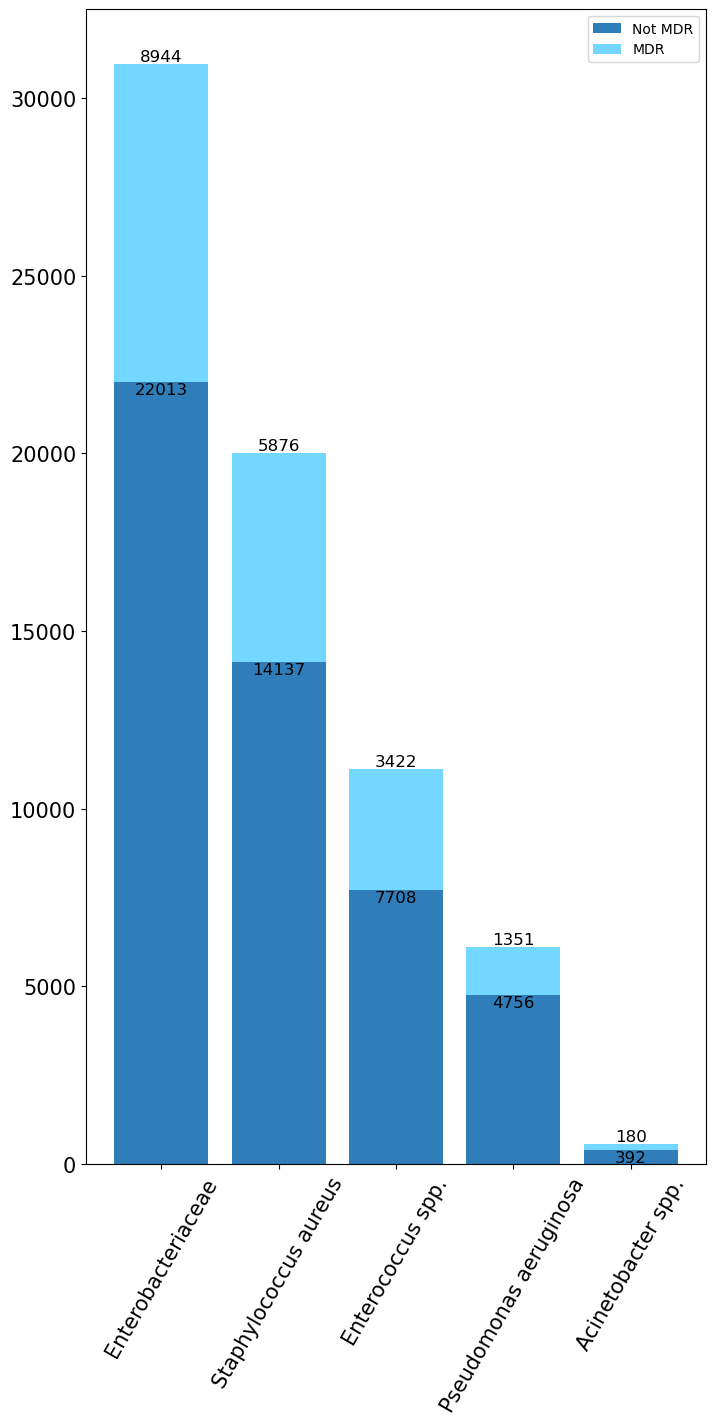

In [50]:
mdr_plot_cat = MDR_CAL_cat[['org_name','MDR']]
mdr_plot_cat = pd.merge(mdr_plot_cat,org_name_sel.iloc[:,1:4],how = 'left', on = 'org_name')
mdr_plot_cat = mdr_plot_cat[~pd.isna(mdr_plot_cat.org_category)]
mdr_plot_cat_bar1 = pd.DataFrame(mdr_plot_cat[mdr_plot_cat['MDR']==1].\
groupby(['org_category','MDR']).count()['org_name']).reset_index().sort_values(by = 'org_name',ascending = False)
mdr_plot_cat_bar0 = pd.DataFrame(mdr_plot_cat[mdr_plot_cat['MDR']==0].\
groupby(['org_category','MDR']).count()['org_name']).reset_index().sort_values(by = 'org_name',ascending = False)
mdr_plot_cat_bar = pd.merge(mdr_plot_cat_bar1,mdr_plot_cat_bar0,how = 'right', on = 'org_category')
#with plt.style.context(['science','notebook','ieee','no-latex']):
plt.figure(figsize= (8,15))
plt.bar(mdr_plot_cat_bar['org_category'],mdr_plot_cat_bar['org_name_y'],\
    color='#307eb9',label='Not MDR')
plt.bar(mdr_plot_cat_bar['org_category'],mdr_plot_cat_bar['org_name_x'],\
color='#74d7ff',bottom=mdr_plot_cat_bar['org_name_y'], label = 'MDR')
plt.tick_params(labelsize = 15)
for x1,x2, y1, y2 in zip(mdr_plot_cat_bar['org_category'], \
mdr_plot_cat_bar['org_category'], mdr_plot_cat_bar['org_name_y'], mdr_plot_cat_bar['org_name_x']):
    plt.text(x1 , y1, '%.0f' % y1, ha='center', va='top',fontsize = 12)
    plt.text(x2 , y1+y2, '%.0f' % y2, ha='center', va='bottom',fontsize = 12)
plt.xticks(rotation = 60)
plt.legend(loc=1)

# 表连接

## 是否最后一次ICU

In [51]:
trans_id(icustays)

In [53]:
icustays.columns

Index(['subject_id', 'hadm_id', 'stay_id', 'gender', 'dod', 'admittime',
       'dischtime', 'los_hospital', 'admission_age', 'race',
       'hospital_expire_flag', 'hospstay_seq', 'first_hosp_stay', 'icu_intime',
       'icu_outtime', 'los_icu', 'icustay_seq', 'first_icu_stay'],
      dtype='object')

In [54]:
last_hospicu = icustays[['subject_id', 'hadm_id', 'stay_id', 'gender', 'dod', 'admittime',
       'dischtime', 'los_hospital', 'admission_age', 'race',
       'hospital_expire_flag', 'hospstay_seq', 'first_hosp_stay', 'icu_intime',
       'icu_outtime', 'los_icu', 'icustay_seq', 'first_icu_stay']].drop_duplicates().groupby(['subject_id']).\
apply(lambda x: x.sort_values(['hospstay_seq','icustay_seq'],ascending = False).head(1)).reset_index(drop = True)

In [55]:
last_hospicu['last'] = 1

In [56]:
icustays = pd.merge(icustays, last_hospicu[['subject_id', 'hadm_id', 'stay_id','last']],\
                    how = 'left', on = ['subject_id', 'hadm_id', 'stay_id'])

In [57]:
icustays['last'].value_counts()

1.0    50920
Name: last, dtype: int64

## 时间聚合

### 将有微生物的结果和没有结果的连接

In [58]:
MDR_CAL_cat_tot = pd.merge(MDR_CAL_cha[['subject_id','micro_specimen_id','org_name']],\
        MDR_CAL_cat,how = 'left', on = ['subject_id','micro_specimen_id','org_name']).\
drop_duplicates()

In [59]:
MDR_CAL_cat_time = pd.merge(MDR_CAL_cat_tot,microevents[['subject_id','hadm_id',\
    'micro_specimen_id','org_name','charttime','spec_type_desc','storetime']],\
    how = 'left', on = ['subject_id','micro_specimen_id','org_name']).drop_duplicates()

In [60]:
MDR_CAL_cat_time = MDR_CAL_cat_time.\
drop_duplicates(subset = ['micro_specimen_id','org_name'],keep = 'first')

In [61]:
# MDR_CAL_cat_time = MDR_CAL_cat_time.\
# drop(columns = ['org_category_x']).rename(columns = {'org_category_y':'org_category'})

In [62]:
def pos_neg(df):
    if (df['org_category'] == 'Staphylococcus aureus') or\
    (df['org_category'] == 'Enterococcus spp.'):
        return 1,0
    elif (df['org_category'] == 'Enterobacteriaceae') or \
    (df['org_category'] == 'Pseudomonas aeruginosa') or  (df['org_category'] == 'Acinetobacter spp.'):
        return 0,1
    else:
        return 0,0

In [63]:
MDR_CAL_cat_time[['org_pos','org_neg']] = MDR_CAL_cat_time.apply(pos_neg, axis = 1, result_type="expand")

In [64]:
MDR_CAL_cat_time[MDR_CAL_cat_time['org_category'] == 'Enterococcus spp.'].org_name.value_counts()

ENTEROCOCCUS SP.              7641
ENTEROCOCCUS FAECIUM          1882
ENTEROCOCCUS FAECALIS         1087
PROBABLE ENTEROCOCCUS          409
ENTEROCOCCUS GALLINARUM         49
ENTEROCOCCUS CASSELIFLAVUS      32
ENTEROCOCCUS AVIUM              17
ENTEROCOCCUS RAFFINOSUS         10
ENTEROCOCCUS HIRAE               3
Name: org_name, dtype: int64

In [65]:
spec_type = MDR_CAL_cat_time[['subject_id','micro_specimen_id','org_name','spec_type_desc']]

In [66]:
pd.pivot_table(data = MDR_CAL_cat_time,values='MDR',\
               index = ['spec_type_desc'],aggfunc= ['count','mean']).\
sort_values(by = [('count','MDR')],ascending = False).head(20)

,count,mean
,MDR,MDR
spec_type_desc,,
URINE,27105,0.296698
BLOOD CULTURE,10437,0.197183
SWAB,7715,0.268697
SPUTUM,6658,0.261190
TISSUE,3529,0.197790
MRSA SCREEN,2817,0.965566
BRONCHOALVEOLAR LAVAGE,1744,0.176606
Staph aureus swab,1682,0.129013


### 第一次MDRO的信息

In [67]:
micro_sim = MDR_CAL_cat_time[['subject_id', 'hadm_id','micro_specimen_id', 'charttime',
       'spec_type_desc','storetime', 'org_name',
       'resistant_ab_cat', 'MDR']].drop_duplicates()

micro_sim['MDR'].fillna(0,inplace = True)

micro_sim_firsthospmdr = micro_sim[micro_sim['MDR']==1].groupby(['subject_id','hadm_id']).\
apply(lambda x: x.sort_values(['storetime','charttime']).head(1)).reset_index(drop = True)

micro_sim_firsthospmdr = micro_sim_firsthospmdr[['subject_id', 'hadm_id',\
                'charttime','storetime','org_name','resistant_ab_cat']].\
rename(columns = {'charttime':'firsthospmdrcharttime',\
                  'storetime':'firsthospmdrstoretime',\
                  'org_name':'firsthospmdrorgname',\
                 'resistant_ab_cat':'firsthospmdrRAB'})

In [68]:
icustay_1stmdr = pd.merge(icustays, micro_sim_firsthospmdr, how = 'left', on = ['subject_id','hadm_id'])

In [69]:
cohort_micro = pd.merge(MDR_CAL_cat_time,icustay_1stmdr, how = 'left', on = ['subject_id'])

In [71]:
for i in ['admittime','dischtime','icu_intime','icu_outtime','charttime','storetime']:
    cohort_micro[i] = cohort_micro[i].apply(trans_time)

In [73]:
cohort_micro['microtest_days'] = round((cohort_micro['charttime'] - cohort_micro['icu_intime']).\
                                       dt.total_seconds()/3600/24,2)
cohort_micro['microresult_days'] = round((cohort_micro['storetime'] - cohort_micro['icu_intime']).\
                                         dt.total_seconds()/3600/24,2)

In [74]:
#在住ICU期间做的微生物检测，如果有检测，则microtest_inicu为1
cohort_micro['los_icu'] = cohort_micro['los_icu'].astype(float)
cohort_micro['microtest_inicu'] = cohort_micro[['microtest_days','los_icu']].\
apply(lambda x: 1 if (x[0]>=0) & (x[0]<=x[1]) else 0, axis = 1)

#在入icu后，出ICU前做过微生物检测的人数
cohort_micro[['stay_id','microtest_inicu']].drop_duplicates().microtest_inicu.value_counts()

0    62815
1    53472
Name: microtest_inicu, dtype: int64

In [75]:
#在入icu前做微生物检测，在入ICU后结果才出来的人数
cohort_micro['microtest_beforeicu'] = cohort_micro[['microtest_days','microresult_days','los_icu']].\
apply(lambda x: 1 if ((x[0]<0) & (x[1]<=x[2]) & (x[1]>0)) else 0, axis = 1)

#在入icu前做微生物检测，在入ICU后，出ICU前结果出来的人数
cohort_micro[['stay_id','microtest_beforeicu']].drop_duplicates().microtest_beforeicu.value_counts()

0    69175
1    23537
Name: microtest_beforeicu, dtype: int64

In [76]:
#在入icu前做微生物检测，在入ICU前结果出来的人数
cohort_micro['microresult_beforeicu'] = cohort_micro[['microtest_days','microresult_days','los_icu']].\
apply(lambda x: 1 if ((x[0]<0) & (x[1]<0)) else 0, axis = 1)

#在入icu前做微生物检测，在入ICU前出结果人数
cohort_micro[['stay_id','microresult_beforeicu']].drop_duplicates().microresult_beforeicu.value_counts()

0    67778
1    41149
Name: microresult_beforeicu, dtype: int64

In [77]:
cohort_micro[cohort_micro['microresult_beforeicu']==1].drop_duplicates().MDR.value_counts()

0.0    51370
1.0    23802
Name: MDR, dtype: int64

In [78]:
cohort_micro.rename(columns = {'hadm_id_x':'hadm_id','hadm_id_y':'hadm_id_icu'},inplace = True)

In [79]:
cohort_WITHMDR = cohort_micro.copy()

In [80]:
cohort_WITHMDR['MDR'] = cohort_WITHMDR['MDR'].fillna(0)

In [81]:
cohort_WITHMDR[cohort_WITHMDR['microtest_inicu']==1].drop_duplicates().MDR.value_counts()

0.0    215472
1.0      6154
Name: MDR, dtype: int64

In [82]:
#cohort_WITHMDR[cohort_WITHMDR['subject_id'] ==10002428.0].to_csv('test3.csv')

In [83]:
cohort_WITHMDR[['subject_id','micro_specimen_id','org_name','org_category']].\
drop_duplicates().org_category.value_counts()

Enterobacteriaceae        30637
Staphylococcus aureus     20013
Enterococcus spp.         11130
Pseudomonas aeruginosa     6107
Acinetobacter spp.          572
Name: org_category, dtype: int64

In [84]:
cohort_WITHMDR.to_csv('cohort_WITHMDR.csv', index = False)

In [ ]:
cohort_WITHMDR